In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import KernelPCA
import plotly.io as pio
from gtda.plotting import plot_diagram
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import glob

%matplotlib inline

# Load data

In [2]:
# Load all features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [3]:
subject_list = ["293", "294", "298"]
label_list = [1, 2, 3, 4, 5, 7]

In [4]:
persistence_diagrams = {}
reshaped_persistence_diagrams = {}
extended_persistence_diagrams = {}
most_representative_diagrams = {}


for subject in subject_list:
    persistence_diagrams[subject] = {}
    reshaped_persistence_diagrams[subject] = {}
    extended_persistence_diagrams[subject] = {}
    most_representative_diagrams[subject] = {}

    
    for data_type in ["EEG", "EMG"]:
        persistence_diagrams[subject][data_type]  = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

    
        reshaped_persistence_diagrams[subject][data_type] = {}

        for label in label_list:
            reshaped_persistence_diagrams[subject][data_type]["Label_"+str(label)] = [persistence_diagram[0] for persistence_diagram in list(persistence_diagrams[subject][data_type]["Label_"+str(label)])]

persistence_diagrams = reshaped_persistence_diagrams

In [5]:
### Example for subject

subject = "293"

In [10]:
data = pd.read_csv("Data/EDF_as_CSV_"+str(subject)+"_complete.csv")

In [11]:
data

,Unnamed: 0,Time,EEG,EMG
0,0,0.000,-0.000024,-0.000125
1,1,0.002,-0.000020,-0.000121
2,2,0.004,0.000008,-0.000064
3,3,0.006,0.000043,-0.000009
4,4,0.008,0.000054,-0.000024
...,...,...,...,...
3919995,3919995,7839.990,0.000004,0.000004
3919996,3919996,7839.992,0.000004,0.000004
3919997,3919997,7839.994,0.000004,0.000004
3919998,3919998,7839.996,0.000004,0.000004


# Plot data directly

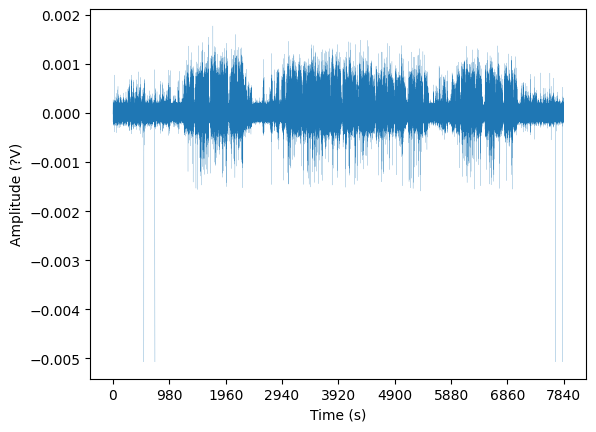

In [12]:

plt.plot(data["EEG"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (s)")
plt.xticks(ticks = [0, 490000,  980000 , 1470000,  1960000,  2450000,  2940000,  3430000,  3920000], labels=[0, 980,  1960,  2940,  3920,  4900,  5880,  6860,  7840])
plt.savefig('Plots/Sleep_EEG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

# Signatures

## Heat Kernel

In [33]:
subject = "293"
data_type = "EMG"

In [20]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

In [34]:
if data_type == "EEG":
    HK = HeatKernel(sigma=0.00003, n_bins=100)
elif data_type == "EMG":
    HK = HeatKernel(sigma=0.00003, n_bins=100)

In [35]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

In [36]:
label = 1
heatkernel = HK.fit_transform([persistence_diagrams[subject][data_type]["Label_"+str(label)][0]])

Heat kernel intensity of label 1 for homology dimension 0: 1794488991.399993


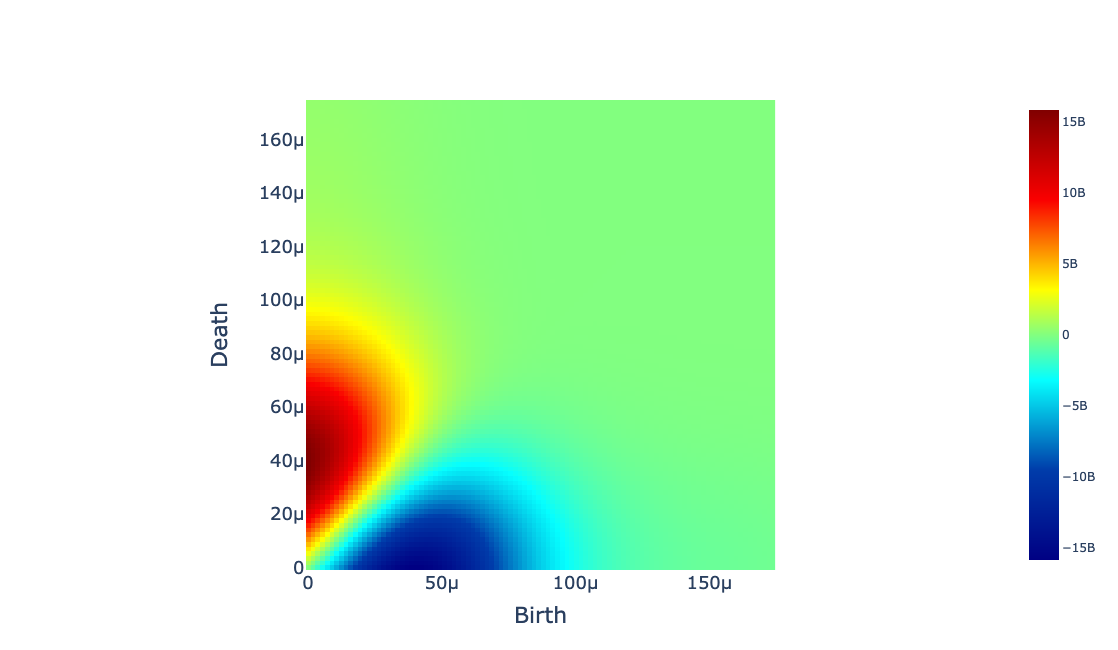

In [38]:
print("Heat kernel intensity of label " + str(label) + " for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

fig = HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
#pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 0 (Label " + str(label) + ").png")


Heat kernel intensity of label 1  for homology dimension 1: 794786559.068151


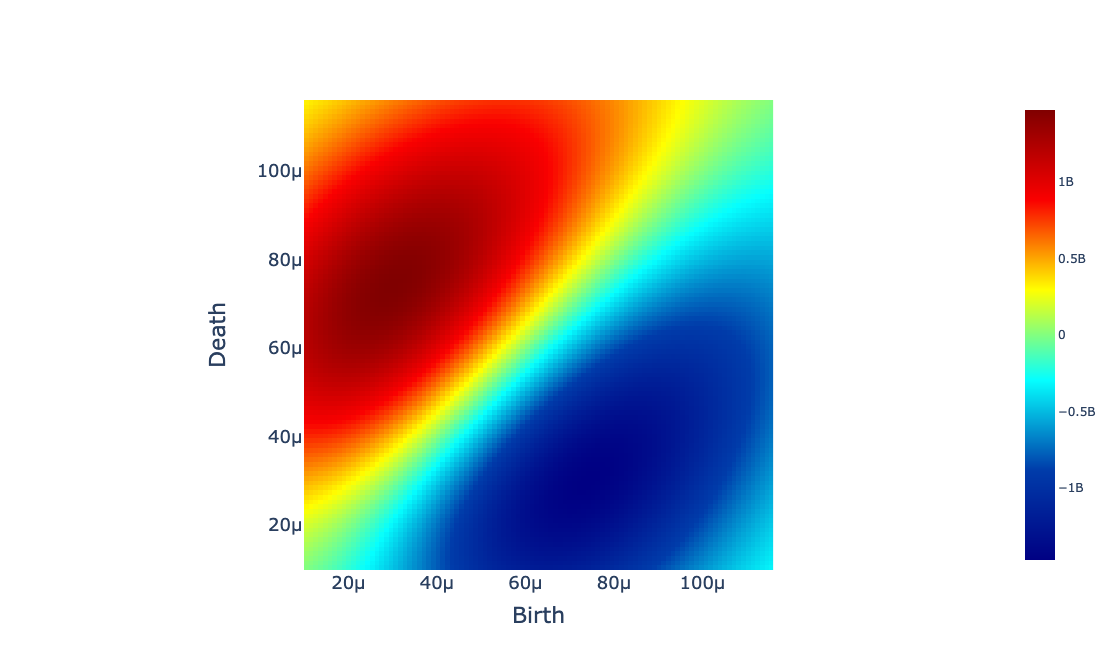

In [39]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 1: " + str(heat_kernel_intensity(heatkernel, 1)))


fig = HK.plot(heatkernel, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
#pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 1 (Label "+str(label)+").png")

Heat kernel intensity of label 0  for homology dimension 2: 0.5452464126434898


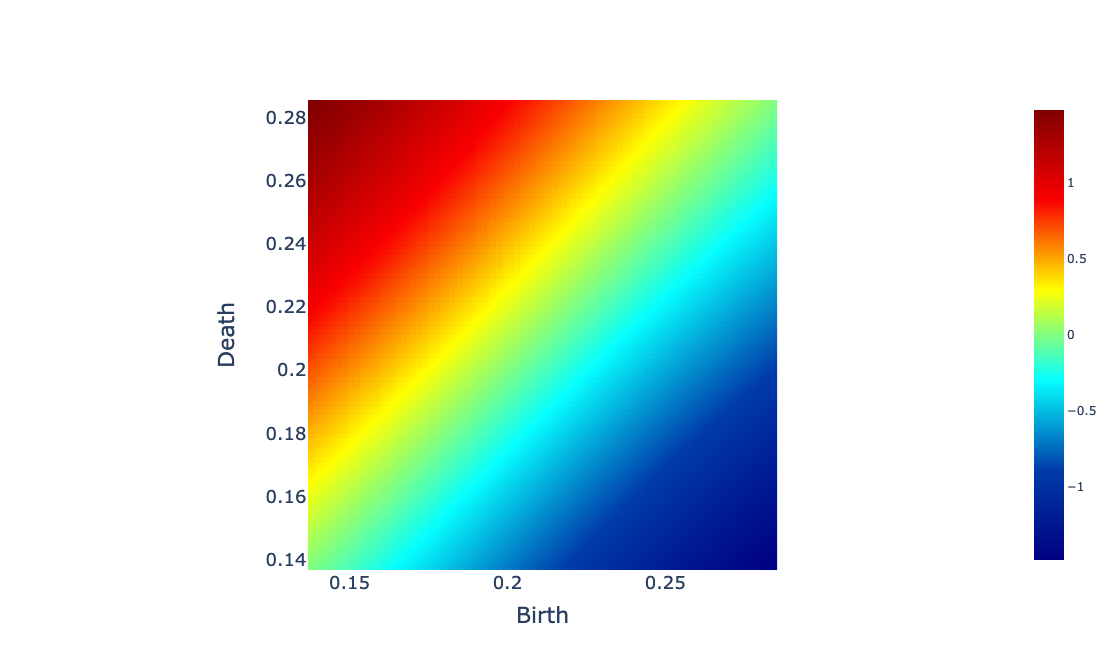

In [291]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 2: " + str(heat_kernel_intensity(heatkernel, 2)))


fig = HK.plot(heatkernel, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 2 (Label "+str(label)+").png")

# Persistence Landscape

In [292]:
PL = PersistenceLandscape()

In [305]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": False,  # Hide the legend
        "title": "", # Remove the title
        "height": 500,  # Set the desired height in pixels
        "margin": dict(l=150, r=50, t=50, b=100)  # Adjust margins if needed
    }
}


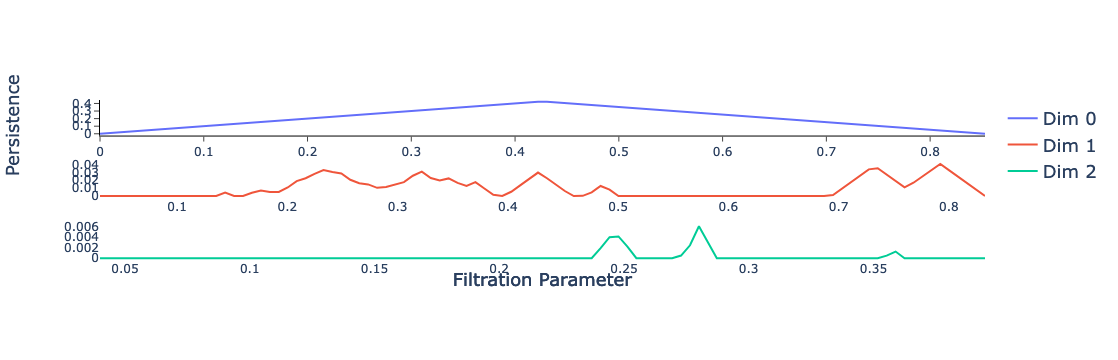

In [316]:
import plotly.io as pio

label = 4
landscape = PL.fit_transform(most_representative_diagrams[subject][data_type]["Label_" + str(label)])

# Generate the initial plot
fig = PL.plot(landscape, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"

# Update layout to add combined axis labels and increase legend font size
fig.update_layout(
    annotations=[
        dict(
            text="Filtration Parameter",
            x=0.5,
            y=-0.2,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=18)
        ),
        dict(
            text="Persistence",
            x=-0.1,
            y=0.5,
            xref="paper",
            yref="paper",
            showarrow=False,
            textangle=-90,
            font=dict(size=18)
        )
    ],
    margin=dict(l=100, r=20, t=100, b=100),  # Adjust margins if necessary
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Landscape_" + str(subject) + "_" + str(data_type) + "(Label " + str(label) + ").png")


# Silhouette

In [317]:
SH = Silhouette()

In [325]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Silhouette Value",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


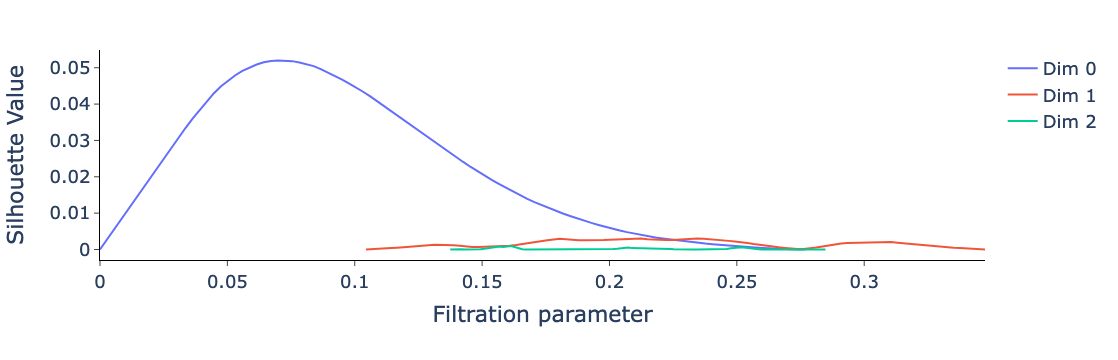

In [327]:
label = 0


silhouette = SH.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = SH.plot(silhouette, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Silhouette_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Betti Curve

In [328]:
BC = BettiCurve()


In [329]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Betti Number",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


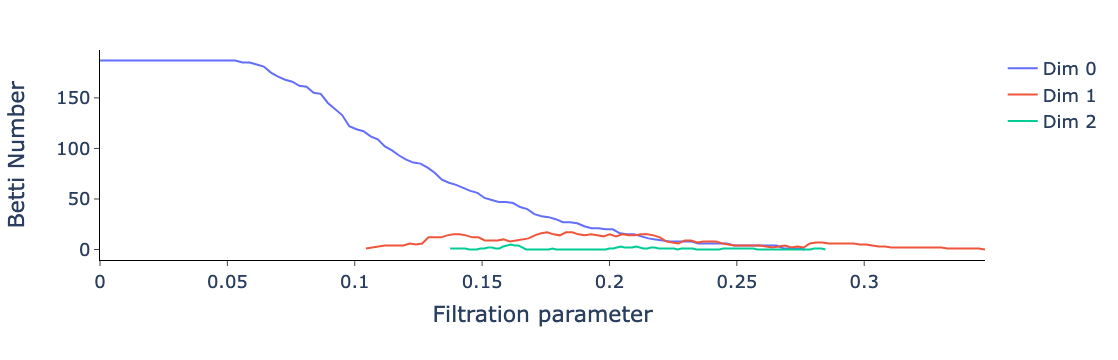

In [331]:
label = 0

betti_curve = BC.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = BC.plot(betti_curve, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Betti_Curve_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Persistence Images

In [334]:
if data_type == "EEG":
    PI = PersistenceImage(sigma=0.2, n_bins=100)
elif data_type == "EMG":
    PI = PersistenceImage(sigma=0.003, n_bins=100)



In [335]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

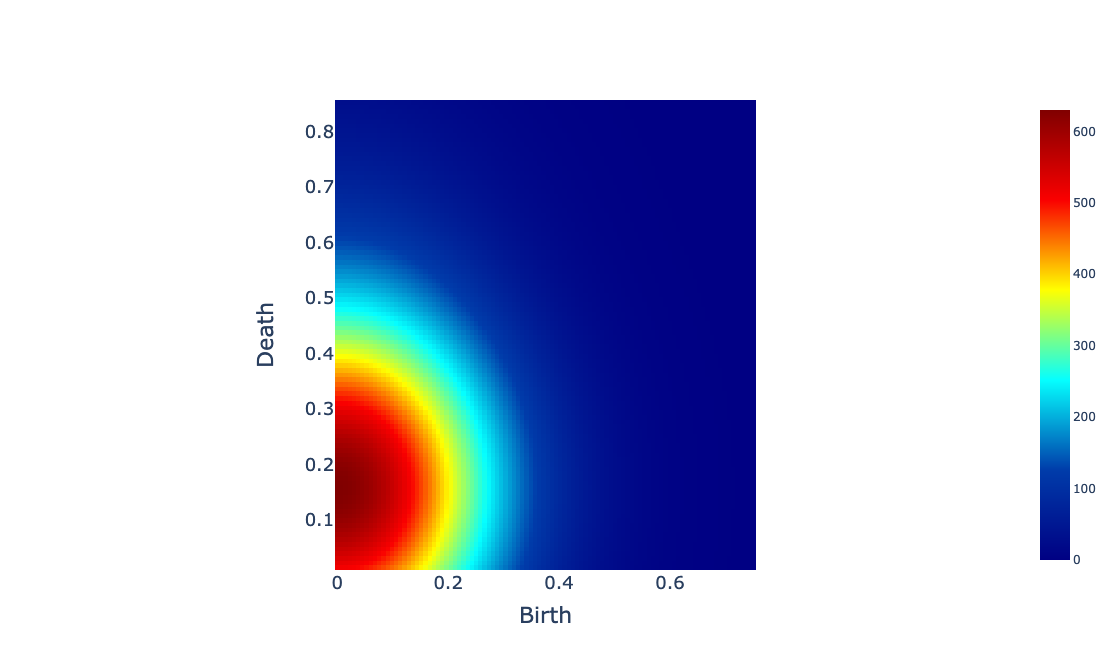

In [341]:
label = 4


persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 0 (Label " + str(label) + ").png")

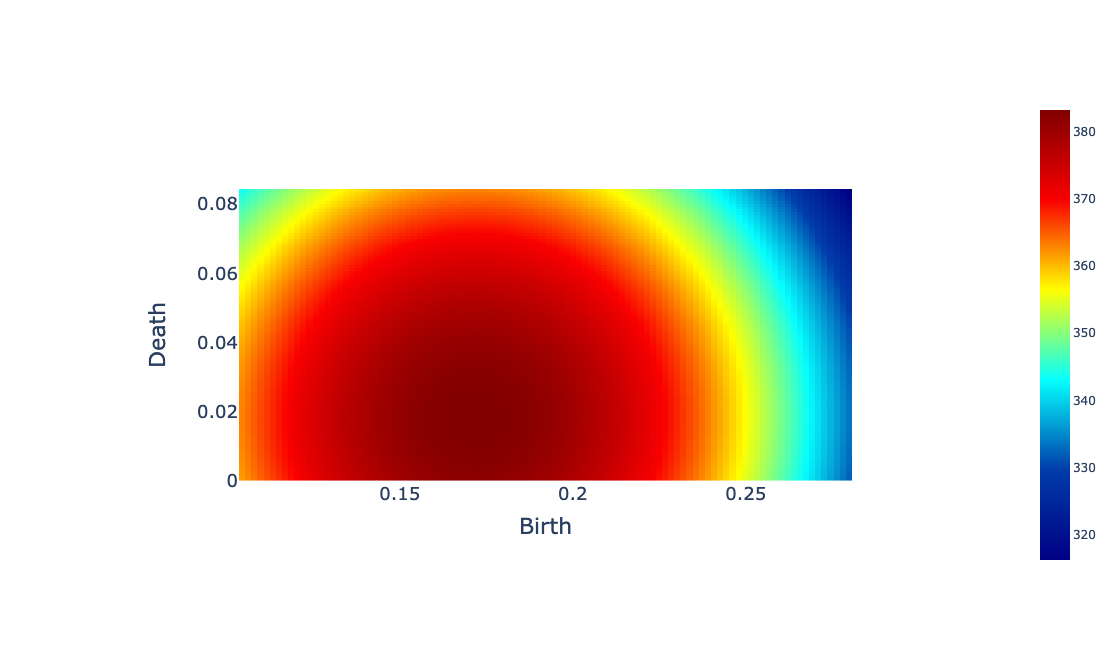

In [338]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 1 (Label " + str(label) + ").png")

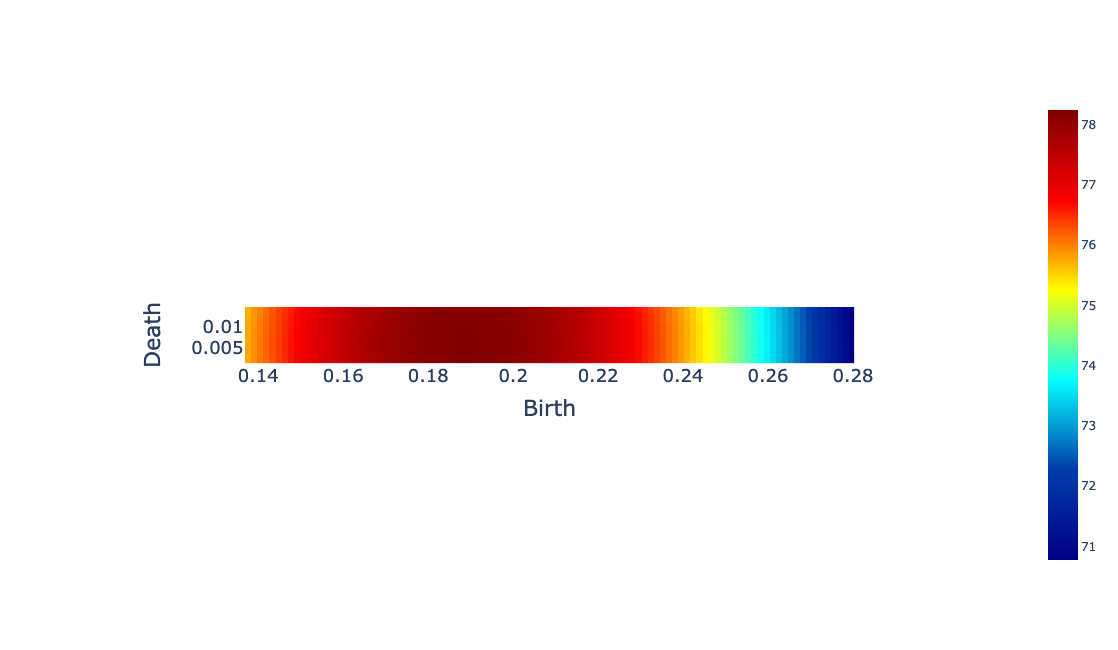

In [339]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 2 (Label " + str(label) + ").png")